In [2]:
import os
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.signal import butter, lfilter
import numpy as np
import pandas as pd
from IPython.display import Audio, display
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Input, Model
from sklearn.model_selection import train_test_split
import csv
import torch
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# GET SAMPLE

In [3]:
num_of_samples = 10

In [4]:
# Function to get all .wav files from a directory
def get_wav_files_from_folder(path):
    return [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.wav')]

# Function to load and display a .wav file
def load_and_display_wav(file_path, num_of_samples):
    try:
        # Load the audio file using librosa
        audio_data, sample_rate = librosa.load(file_path, sr=None)

        # Plot the waveform
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio_data, sr=sample_rate)
        plt.title(f'Waveform of {os.path.basename(file_path)}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()
        return audio_data, sample_rate
    except Exception as e:
        print(f"Error loading or displaying {file_path}: {e}")

# Function to randomly select files from the lists
def select_random_files(real_files, fake_files, num_real, num_fake):
    if not real_files:
        print("No real files found!")
    if not fake_files:
        print("No fake files found!")

    # Select random files from the real and fake lists
    selected_real_files = random.sample(real_files, min(num_real, len(real_files)))
    selected_fake_files = random.sample(fake_files, min(num_fake, len(fake_files)))

    return selected_real_files, selected_fake_files

# Paths to the real and fake directories (replace with your actual paths)
real_path = "./content/LibriSeVoc/diffwave"
fake_path = "./content/LibriSeVoc/gt"

# Load the lists of .wav files from each directory
real_files = get_wav_files_from_folder(real_path)
fake_files = get_wav_files_from_folder(fake_path)

# Get lists of 10 random real and fake file paths
random_real_files, random_fake_files = select_random_files(real_files, fake_files, num_real=num_of_samples, num_fake=num_of_samples)

Real_Audio = []
Fake_Audio = []

# # Display the real files
# print("Displaying random real files:")
# for file in random_real_files:
#     Real_Audio.append(load_and_display_wav(file, num_of_samples))

# # Display the fake files
# print("Displaying random fake files:")
# for file in random_fake_files:
#     Fake_Audio.append(load_and_display_wav(file, num_of_samples))

# print(len(Real_Audio))
# print(len(Fake_Audio))

In [5]:
def play_audio(audio_data_list):
    for audio_data, sample_rate in audio_data_list:
        print(f"Playing audio with sample rate: {sample_rate} Hz")
        ipd.display(ipd.Audio(data=audio_data, rate=sample_rate))

print("Real Audio")
play_audio(Real_Audio)
print("Fake Audio")
play_audio(Fake_Audio)

Real Audio
Fake Audio


# *PREPROCESSING FUNCTION*

In [6]:
# Check if MPS (Metal Performance Shaders) is available and set the device accordingly
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [7]:
import torch
from scipy.signal import butter, lfilter

# Check MPS availability and set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

def bandpass_filter(y, sr, lowcut=250, highcut=4000, order=5):
    """
    Applies a bandpass filter to an audio signal.

    Args:
        y (torch.Tensor): The audio signal as a PyTorch tensor.
        sr (int): The sample rate of the audio signal.
        lowcut (int, optional): The lower cutoff frequency. Defaults to 250.
        highcut (int, optional): The upper cutoff frequency. Defaults to 4000.
        order (int, optional): The order of the filter. Defaults to 5.

    Returns:
        torch.Tensor: The filtered audio signal as a PyTorch tensor.
    """
    # Perform the filtering (this part uses scipy and will run on the CPU)
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y_filtered = lfilter(b, a, y)  # Move to CPU for scipy

    # Move the filtered signal back to the original device
    return torch.tensor(y_filtered, dtype=y.dtype).to(device)

Using device: mps


In [8]:
import torch

def decrease_low_db(y, sr, threshold_db=-50, target_db=-80):
    """
    Giảm độ lớn của các mẫu âm thanh dưới ngưỡng dB cho trước đến độ to mong muốn,
    giữ nguyên thời gian của tín hiệu âm thanh.

    :param y: Tín hiệu âm thanh (tensor)
    :param sr: Tần số lấy mẫu (Hz)
    :param threshold_db: Ngưỡng dB để xác định các mẫu cần giảm độ lớn (ví dụ: -40 dB)
    :param target_db: Độ to mong muốn cho các mẫu dưới ngưỡng (ví dụ: -80 dB)
    :return: Tín hiệu đã được điều chỉnh (tensor)
    """
    # Calculate the absolute amplitude of the signal
    abs_y = torch.abs(y)

    # Calculate the reference amplitude (maximum amplitude)
    ref_amplitude = torch.max(abs_y) if torch.max(abs_y) > 0 else torch.tensor(1.0, dtype=torch.float32).to(device)

    # Calculate the dB level of each sample relative to the reference amplitude
    y_db = 20 * torch.log10(abs_y / ref_amplitude + 1e-10)  # Add epsilon to avoid log(0)

    # Create a mask for samples below the dB threshold
    mask = y_db < threshold_db

    # Calculate the desired amplitude for samples below the dB threshold
    desired_amplitude = 10 ** (target_db / 20) * ref_amplitude  # Example: -80 dB

    # Create a copy of the signal to adjust
    y_adjusted = y.clone()

    # Reduce the amplitude of samples below the dB threshold
    # Avoid division by zero by adding epsilon
    y_adjusted[mask] = y_adjusted[mask] / (abs_y[mask] + 1e-10) * desired_amplitude

    return y_adjusted  # Convert back to numpy array if needed

# SHOW PROCESSED INSTANCES


In [9]:
# Filtered_Real_Audio = []
# for audio_data, sample_rate in Real_Audio:
#     filtered_audio = bandpass_filter(audio_data, sample_rate, lowcut=250, highcut=4000)
#     final_audio = decrease_low_db(filtered_audio, sample_rate)
#     Filtered_Real_Audio.append(final_audio)

# Filtered_Fake_Audio = []
# for audio_data, sample_rate in Fake_Audio:
#     filtered_audio = bandpass_filter(audio_data, sample_rate, lowcut=250, highcut=4000)
#     filtered_audio = decrease_low_db(filtered_audio, sample_rate)
#     Filtered_Fake_Audio.append(filtered_audio)


In [10]:

# def play_and_show_wave_spectrogram(audio_data, sample_rate, title):
#     """Plays audio, displays waveform, and spectrogram."""
#     ipd.display(ipd.Audio(data=audio_data, rate=sample_rate))  # Play audio

#     # Display waveform
#     # plt.figure(figsize=(10, 4))
#     # librosa.display.waveshow(audio_data, sr=sample_rate)
#     # plt.title(f"{title} - Waveform")
#     # plt.xlabel("Time (s)")
#     # plt.ylabel("Amplitude")
#     # plt.tight_layout()
#     # plt.show()

#     # Display spectrogram
#     # plt.figure(figsize=(10, 4))
#     # D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
#     # librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
#     # plt.colorbar(format='%+2.0f dB')
#     # plt.title(f"{title} - Spectrogram")
#     # plt.tight_layout()
#     # plt.show()

# # Play, display waveform, and spectrogram for Filtered_Real_Audio
# print("Real Audio Display")
# for i, audio_data in enumerate(Filtered_Real_Audio):
#     play_and_show_wave_spectrogram(audio_data, Real_Audio[i][1], f"Filtered Real Audio {i+1}")

# # Play, display waveform, and spectrogram for Filtered_Fake_Audio
# print("Fake Audio Display")
# for i, audio_data in enumerate(Filtered_Fake_Audio):
#     play_and_show_wave_spectrogram(audio_data, Fake_Audio[i][1], f"Filtered Fake Audio {i+1}")

# TRAIN TEST SPLIT

In [11]:
# Define the main data directory

# List to hold file paths
train_file_paths = []
test_file_paths = []

label_dict = {
    fake_path: 0,
    real_path: 1
}

# Split ratio
train_ratio = 0.8

# Split files in each class directory
for class_dir in [fake_path, real_path]:

    # Get all file paths for the class
    all_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.wav')]

    # Split into train and test sets
    train_files, test_files = train_test_split(all_files, train_size=train_ratio, random_state=42)

    # Append to the respective lists with corresponding labels (class)
    for file_path in train_files:
        train_file_paths.append((file_path, label_dict[class_dir]))  # Store path and label
    for file_path in test_files:
        test_file_paths.append((file_path, label_dict[class_dir]))

print(f"Train file paths: {len(train_file_paths)}")
print(f"Test file paths: {len(test_file_paths)}")


Train file paths: 21120
Test file paths: 5282


In [12]:

# File paths to save the CSVs
train_csv = 'output/train_file_paths.csv'
test_csv = 'output/test_file_paths.csv'

# Save train_file_paths to CSV
with open(train_csv, mode='w', newline='') as train_file:
    writer = csv.writer(train_file)
    writer.writerow(['file_path', 'label'])  # Write the header
    for file_path, label in train_file_paths:
        writer.writerow([file_path, label])  # Write the file path and label

# Save test_file_paths to CSV
with open(test_csv, mode='w', newline='') as test_file:
    writer = csv.writer(test_file)
    writer.writerow(['file_path', 'label'])  # Write the header
    for file_path, label in test_file_paths:
        writer.writerow([file_path, label])  # Write the file path and label

print(f"Train file paths saved to {train_csv}")
print(f"Test file paths saved to {test_csv}")


Train file paths saved to output/train_file_paths.csv
Test file paths saved to output/test_file_paths.csv


# DATA PROCESSING

In [13]:
SEGMENT_LENGTH = 1
NUM_SEGMENT = 30
SR = 24000
BATCH_SIZE = 32
LR = 0.0001
EPOCHS = 30

In [14]:
# Check if MPS (Metal Performance Shaders) is available and set the device accordingly
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [15]:
import torch
import torchaudio
import torchaudio.transforms as T

# Check MPS availability and set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

def segment_to_spectrogram(segment, sr=24000, n_fft=2048, hop_length=512, n_mels=128):
    """
    Extracts a Mel spectrogram from an audio segment, ensuring execution on the MPS GPU if available.

    Args:
        segment (torch.Tensor): The audio segment as a PyTorch tensor.
        sr (int, optional): The sample rate of the audio segment. Defaults to 24000.
        n_fft (int, optional): The size of the FFT. Defaults to 2048.
        hop_length (int, optional): The hop length for the STFT. Defaults to 512.
        n_mels (int, optional): The number of Mel filterbanks. Defaults to 128.

    Returns:
        torch.Tensor: The Mel spectrogram in decibels (dB).
    """

    # Create the MelSpectrogram transform
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    ).to(device)  # Ensure the transform is also on the correct device

    # Apply the MelSpectrogram transform
    mel_spectrogram = mel_spectrogram(segment)

    # Convert to decibels (dB)
    spectrogram_db = T.AmplitudeToDB().to(device)  # Move AmplitudeToDB to the device
    spectrogram_db = spectrogram_db(mel_spectrogram)

    return spectrogram_db

Using device: mps


In [16]:
import torchaudio
import torch

import torchaudio.transforms as T

def extract_segments(audio_file, segment_length=SEGMENT_LENGTH, num_segments=NUM_SEGMENT):
    # Load audio file using torchaudio
    waveform, sr = torchaudio.load(audio_file)
    waveform = bandpass_filter(waveform, sr, lowcut=250, highcut=4000)
    waveform = torch.tensor(waveform, dtype=torch.float32).to(device)
    waveform = decrease_low_db(waveform, sr)

    # Resample if necessary
    if sr != SR:
        resampler = T.Resample(orig_freq=sr, new_freq=SR)
        waveform = resampler(waveform)
        sr = SR

    # Calculate the total duration in seconds
    total_duration = waveform.shape[1] / sr

    # Calculate the overlap to ensure exactly num_segments
    overlap = (total_duration - segment_length) / (num_segments - 1)

    # Convert segment length and overlap to samples
    segment_samples = int(segment_length * sr)
    overlap_samples = int(overlap * sr)

    # Extract the segments
    segments = []
    for i in range(num_segments):
        start_sample = i * overlap_samples
        end_sample = start_sample + segment_samples
        segment = waveform[:, start_sample:end_sample]
        spectrogram = segment_to_spectrogram(segment)
        segments.append(spectrogram)

    return segments

# Example usage
audio_file = './content/LibriSeVoc/gt/19_227_000003_000000.wav'
segments = extract_segments(audio_file)
print(f"Extracted {len(segments)} segments")

/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_43857/2508326885.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform = torch.tensor(waveform, dtype=torch.float32).to(device)


Extracted 30 segments


In [17]:
# Load the CSV containing train and validation file paths and labels
train_csv = './output/train_file_paths.csv'  # Path to the train data CSV

train_data = pd.read_csv(train_csv)

train_data_head = train_data.head(1000)
train_data_tail = train_data.tail(1000)
train_data_tail = train_data_tail.reset_index(drop=True)
train_data_head = train_data_head.reset_index(drop=True)


# Concatenate the head and tail along rows (axis=0)
demo_train_data = pd.concat([train_data_head, train_data_tail], axis=0)
demo_train_data = demo_train_data.reset_index(drop=True)

# Display the merged data
print(demo_train_data)


                                              file_path  label
0     ./content/LibriSeVoc/gt/60_121082_000096_00000...      0
1     ./content/LibriSeVoc/gt/8312_279790_000004_000...      0
2     ./content/LibriSeVoc/gt/3168_173564_000017_000...      0
3     ./content/LibriSeVoc/gt/7302_86814_000053_0000...      0
4     ./content/LibriSeVoc/gt/4813_248638_000012_000...      0
...                                                 ...    ...
1995  ./content/LibriSeVoc/diffwave/1116_132851_0000...      1
1996  ./content/LibriSeVoc/diffwave/87_121553_000086...      1
1997  ./content/LibriSeVoc/diffwave/2002_139469_0000...      1
1998  ./content/LibriSeVoc/diffwave/1088_129236_0000...      1
1999  ./content/LibriSeVoc/diffwave/3168_173565_0000...      1

[2000 rows x 2 columns]


In [18]:
SAVE_PATH = './output/train_data_checkpoint/train_data_partial'
SAVE_INTERVAL = 100

def load_data(data, segment_length=SEGMENT_LENGTH, num_segments=NUM_SEGMENT, save_interval=SAVE_INTERVAL, save_path=SAVE_PATH, start_index=0):
    segments = []
    labels = []
    # Check for existing partial files
    partial_files = [f for f in os.listdir(os.path.dirname(save_path)) if f.startswith(os.path.basename(save_path)) and f.endswith('.pt')]
    num_partial_files = len(partial_files)
    if start_index == 0:
        start_index = num_partial_files * save_interval
    else:
        start_index = start_index * save_interval
    print(f"Resuming from index {start_index}")

    if num_partial_files * save_interval >= len(data): # Check if all files have been processed
        print("Already finished processing. Merging.")
        return
    else:
        print("Continuing processing from the last checkpoint.")

    for idx, (_, row) in tqdm(enumerate(data.iterrows()), total=len(data)):
        if idx < start_index:
            continue

        file_path = row['file_path']
        label = row['label']

        # Extract segments from the audio file
        file_segments = extract_segments(file_path, segment_length, num_segments)

        # Stack the segments and convert to torch tensor
        file_segments_stacked = torch.stack([torch.tensor(segment, dtype=torch.float32) for segment in file_segments])

        # Append the stacked segments and their corresponding labels
        segments.append(file_segments_stacked)  # Append the 30 segments as a single element
        labels.append(label)  # Append the label only once per file

        # Save progress every save_interval
        if (idx + 1) % save_interval == 0 or (idx + 1) == len(data):
            partial_path = f"{save_path}_{int((idx + 1))}.pt"
            torch.save({'segments': segments, 'labels': labels}, partial_path)
            print(f"{len(segments)} saved at index {idx + 1} to {partial_path}")  # More informative print
            print({'segments': segments[0], 'labels': labels[0]}) # Check the saved data
            segments = []
            labels = []

    print("All segments saved individually.")

def load_saved_segments(data, save_path=SAVE_PATH):
    all_segments = []
    all_labels = []

    # Load all partial files in the SAVE_PATH subdir
    partial_files = [f for f in os.listdir(os.path.dirname(save_path)) if f.startswith(os.path.basename(save_path)) and f.endswith('.pt')]
    for partial_file in partial_files:
        print(f"Loading {partial_file}")
        partial_data = torch.load(os.path.join(os.path.dirname(save_path), partial_file))
        print(f"Loaded {len(partial_data['segments'])} segments from {partial_file}")
        all_segments.extend(partial_data['segments'])  # Extend directly with the list of stacked segments
        all_labels.extend(partial_data['labels'])  # Extend the labels list
    print("Finished loading, stacking loaded tensors...")
    return torch.stack([segment.cpu() for segment in all_segments]), torch.tensor(all_labels, dtype=torch.float32).cpu()


if os.path.exists(SAVE_PATH + '.pt'):
    # Load train and validation data
    data = torch.load(SAVE_PATH + '.pt')
    train_segments = data['segments']
    print(f"Loaded {len(train_segments)} segments")
    train_labels = data['labels']
else:
    print("Loading and saving train data: ", len(train_data))
    # Load the train and validation data
    load_data(train_data)  # Save segments individually
    train_segments, train_labels = load_saved_segments(train_data)  # Load and combine saved segments
    print("Completed loading train data. Saving...")
    # Save the train and validation data
    torch.save({'segments': train_segments, 'labels': train_labels}, f'{SAVE_PATH}.pt')

train_segments = np.array([segment.cpu().numpy() for segment in train_segments])
train_segments = np.transpose(train_segments, (0, 1, 3, 4, 2))
train_labels = train_labels.cpu().numpy().astype(int)
print(f"Train segments shape: {train_segments.shape}, Train labels shape: {train_labels.shape}")

Loading and saving train data:  21120
Resuming from index 21200
Already finished processing. Merging.
Loading train_data_partial_19700.pt
Loaded 100 segments from train_data_partial_19700.pt
Loading train_data_partial_17800.pt
Loaded 100 segments from train_data_partial_17800.pt
Loading train_data_partial_8600.pt


/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_43857/562766099.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  partial_data = torch.load(os.path.join(os.pat

Loaded 100 segments from train_data_partial_8600.pt
Loading train_data_partial_20600.pt
Loaded 100 segments from train_data_partial_20600.pt
Loading train_data_partial_6900.pt
Loaded 100 segments from train_data_partial_6900.pt
Loading train_data_partial_13900.pt
Loaded 100 segments from train_data_partial_13900.pt
Loading train_data_partial_21000.pt
Loaded 100 segments from train_data_partial_21000.pt
Loading train_data_partial_9000.pt
Loaded 100 segments from train_data_partial_9000.pt
Loading train_data_partial_18100.pt
Loaded 100 segments from train_data_partial_18100.pt
Loading train_data_partial_2800.pt
Loaded 100 segments from train_data_partial_2800.pt
Loading train_data_partial_11500.pt
Loaded 100 segments from train_data_partial_11500.pt
Loading train_data_partial_5300.pt
Loaded 100 segments from train_data_partial_5300.pt
Loading train_data_partial_14200.pt
Loaded 100 segments from train_data_partial_14200.pt
Loading train_data_partial_15400.pt
Loaded 100 segments from train

In [19]:
train_segments

array([[[[[-65.54217   ],
          [-60.281723  ],
          [-42.98317   ],
          ...,
          [-44.76814   ],
          [-32.495056  ],
          [  3.4803028 ]],

         [[-68.65613   ],
          [-57.45742   ],
          [-40.169147  ],
          ...,
          [-48.54731   ],
          [-32.342743  ],
          [  3.9460301 ]],

         [[-60.479317  ],
          [-56.470573  ],
          [-38.855312  ],
          ...,
          [-49.629025  ],
          [-32.537815  ],
          [  4.304605  ]],

         ...,

         [[-52.179035  ],
          [-52.62101   ],
          [-39.832695  ],
          ...,
          [-33.06832   ],
          [-42.181515  ],
          [-27.267422  ]],

         [[-53.6309    ],
          [-52.26023   ],
          [-41.20694   ],
          ...,
          [-32.34794   ],
          [-42.55062   ],
          [-27.74234   ]],

         [[-54.477886  ],
          [-53.059235  ],
          [-39.85242   ],
          ...,
          [-32.114967  ],
 

In [20]:
data = torch.load(SAVE_PATH + '.pt')
train_segments = data['segments']
print(f"Loaded {len(train_segments)} segments")
train_labels = data['labels']

/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_43857/3553048317.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(SAVE_PATH + '.pt')


Loaded 21120 segments


In [21]:
# Split the train data further into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_segments, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

print(f"Train segments shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation segments shape: {X_val.shape}, Validation labels shape: {y_val.shape}")

Train segments shape: torch.Size([16896, 30, 1, 128, 47]), Train labels shape: torch.Size([16896])
Validation segments shape: torch.Size([4224, 30, 1, 128, 47]), Validation labels shape: torch.Size([4224])


In [22]:
X_val

tensor([[[[[-5.6914e+01, -5.1242e+01, -4.2501e+01,  ..., -5.6604e+01,
            -4.8561e+01, -2.5888e+01],
           [-5.6177e+01, -5.6727e+01, -4.2643e+01,  ..., -5.3240e+01,
            -5.0662e+01, -2.4311e+01],
           [-5.0194e+01, -4.9637e+01, -4.0478e+01,  ..., -5.5511e+01,
            -4.6578e+01, -2.3760e+01],
           ...,
           [-4.0940e+01, -4.6243e+01, -4.1154e+01,  ..., -3.4576e+01,
            -3.3389e+01, -3.3928e+01],
           [-3.8758e+01, -4.4365e+01, -4.1354e+01,  ..., -3.3450e+01,
            -3.3819e+01, -3.3318e+01],
           [-3.8213e+01, -4.3825e+01, -4.0731e+01,  ..., -3.2469e+01,
            -3.4448e+01, -3.3269e+01]]],


         [[[-4.8131e+01, -3.7564e+01, -3.7603e+01,  ..., -4.0980e+01,
            -4.1717e+01, -2.6071e+01],
           [-3.4628e+01, -3.5749e+01, -4.3632e+01,  ..., -4.4798e+01,
            -4.6649e+01, -2.5496e+01],
           [-3.0827e+01, -3.3075e+01, -4.0766e+01,  ..., -4.1841e+01,
            -4.0036e+01, -2.5018e+01],

In [23]:
del train_segments, train_labels, data  # Clear memory

# MODEL

In [24]:
initializer = tf.keras.initializers.GlorotNormal()

def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), input_shape=input_shape, padding='same', kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.GlobalAveragePooling2D(),  # Outputs a 1D feature vector for each segment
    ])
    return model

# Assume input_shape is (num_freq_bins, time_steps, 1)
input_shape = (128, 47, 1)  # Example input shape based on typical spectrogram size
cnn_model = create_cnn_model(input_shape)

# Input for multiple segments
num_segments = NUM_SEGMENT  # Example number of segments per audio file
segment_input = Input(shape=(num_segments, *input_shape))

# Apply CNN model to each segment
cnn_features = layers.TimeDistributed(cnn_model)(segment_input)  # Shape: (batch, num_segments, feature_dim)
# Add LSTM layers (batch_size, timesteps, input_dim)
lstm_layer = layers.LSTM(128, return_sequences=True)(cnn_features)
lstm_layer = layers.Dropout(0.3)(lstm_layer)
lstm_layer = layers.LSTM(128, return_sequences=True)(lstm_layer)
lstm_layer = layers.Dropout(0.3)(lstm_layer)
lstm_layer = layers.LSTM(128, return_sequences=False)(lstm_layer)

# Classification Layer
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(lstm_layer)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=segment_input, outputs=output)

/Users/ronan/Developer/deepfake-audio-detector/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ronan/Developer/deepfake-audio-detector/venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2024-11-30 14:37:08.385396: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-11-30 14:37:08.389066: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-11-30 14:37:08.389074: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-11-30 14:37:08.389137: I tensorflow/core/common_runtime/pluggable_device/pluggable_

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 128, 47, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 128)        │        93,568 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 587,265 (2.24 MB)

 Trainable params: 586,817 (2.24 MB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
# Cell nay Nam them vao

initial_learning_rate = 0.0001 # Your initial learning rate
decay_steps = 10000  # Number of steps to decay over
decay_rate = 0.9  # Decay rate

# lr_schedule = ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=decay_steps,
#     decay_rate=decay_rate,
#     staircase=True  # Use staircase decay (optional)
# )
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)

In [27]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)

In [28]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# TRAINING

In [29]:
import json
from keras.callbacks import Callback

MODEL_PATH = './output/best_model.keras'
HISTORY_PATH = './output/train_history.json'

class SaveHistory(Callback):
    def __init__(self, filepath=HISTORY_PATH):
        super().__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        # Save the history to a JSON file
        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                history = json.load(f)
        else:
            history = {}

        for key, value in logs.items():
            if key in history:
                history[key].append(value)
            else:
                history[key] = [value]

        with open(self.filepath, 'w') as f:
            json.dump(history, f)


checkpoint_callback = ModelCheckpoint(
    filepath=MODEL_PATH,  # Save weights with epoch number
    monitor='val_loss',
    save_best_only=True,  # Save weights every epoch, not just the best
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
save_history_callback = SaveHistory()
callbacks = [checkpoint_callback, early_stopping, save_history_callback]

In [30]:
X_train.shape

torch.Size([16896, 30, 1, 128, 47])

In [ ]:
initial_epoch = 0
old_history = None
if os.path.exists(MODEL_PATH):
    model = models.load_model(MODEL_PATH)
    print(model)
if os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, 'r') as f:
        history = json.load(f)
        print(history)
        initial_epoch = len(history['loss'])
        print(f"Resuming from epoch {initial_epoch}")


history = model.fit(X_train, y_train, epochs=200, batch_size=128, shuffle=True, validation_data=(X_val, y_val), callbacks=callbacks, initial_epoch=initial_epoch)

if old_history:
    history.history = {key: value + old_history[key] for key, value in history.history.items()}

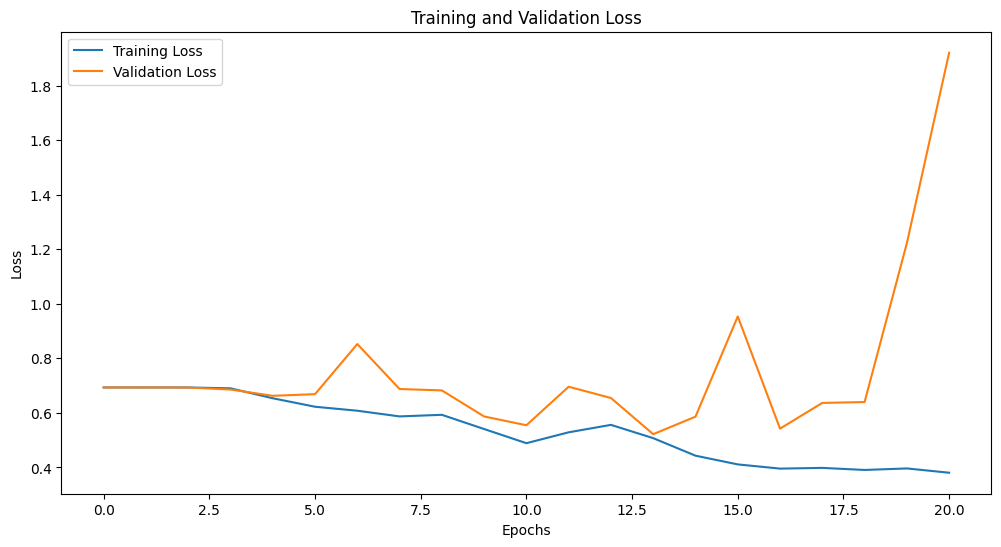

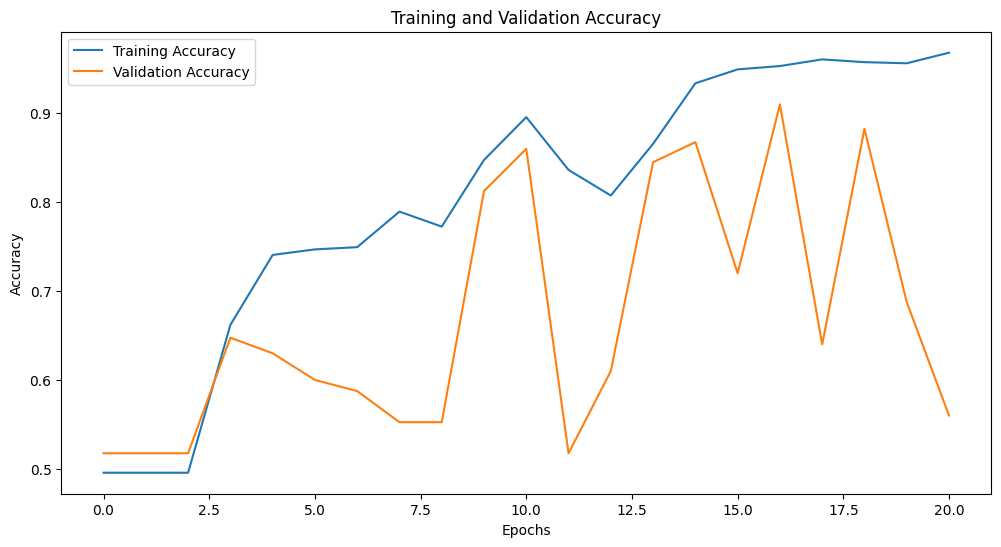

In [ ]:
import json

import matplotlib.pyplot as plt

# Load the training history from the JSON file
with open(HISTORY_PATH, 'r') as f:
    history = json.load(f)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()